In [73]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [74]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [75]:
len(words)

32033

In [76]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [77]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [78]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [79]:
hpreact.shape

torch.Size([32, 200])

In [80]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [81]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [82]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.5 if i < 100000 else 0.05 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.1377
  20000/ 200000: 2.7776
  30000/ 200000: 2.1169
  40000/ 200000: 2.3743
  50000/ 200000: 2.0010
  60000/ 200000: 2.3485
  70000/ 200000: 2.5009
  80000/ 200000: 2.5111
  90000/ 200000: 2.2678
 100000/ 200000: 2.3287
 110000/ 200000: 2.5155
 120000/ 200000: 1.6931
 130000/ 200000: 2.1648
 140000/ 200000: 2.3387
 150000/ 200000: 2.2513
 160000/ 200000: 1.9366
 170000/ 200000: 2.4898


tensor(0.5050) tensor(0.2868)
tensor(2.5541) tensor(0.7022)


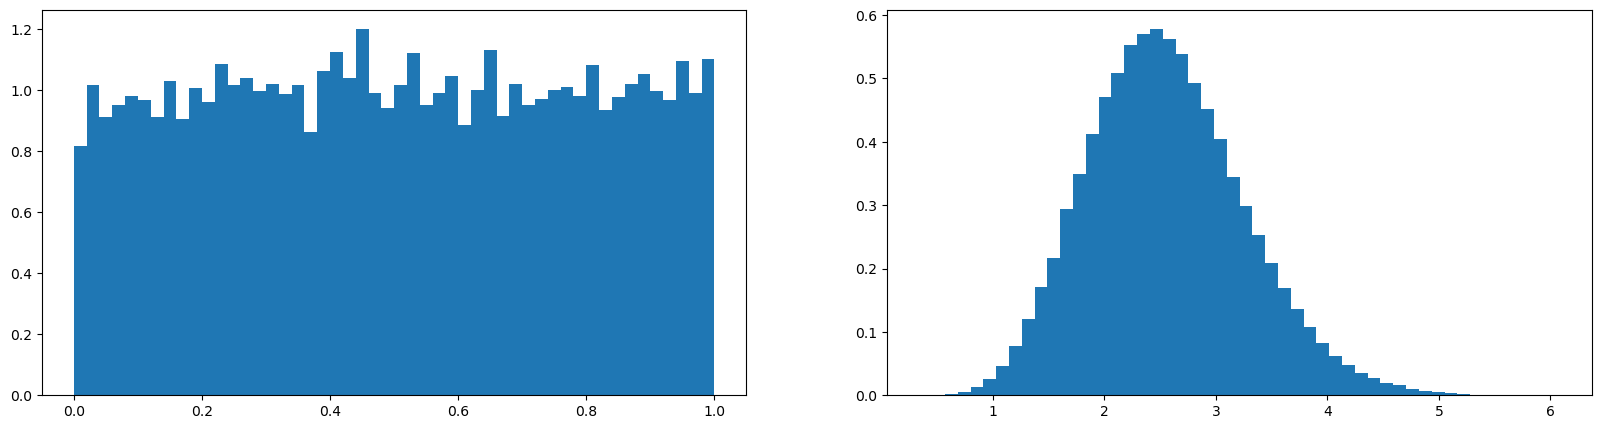

In [ ]:
x = torch. rand (1000, 10)
w = torch. rand (10, 200)
yy = x @ w
print (x.mean(), x.std())
print(yy.mean(), yy.std())
plt.figure(figsize= (20, 5))
plt.subplot (121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot (122)
plt.hist(yy.view(-1).tolist(), 50, density=True);

(array([146., 183., 194., 164., 177., 167., 129., 136., 132., 140., 120.,
        143., 120., 118., 112.,  98., 112., 114., 121.,  91.,  95., 108.,
        107., 109., 113., 108.,  77.,  95.,  98.,  93.,  92., 114., 121.,
         88., 118., 107.,  84., 114., 135., 110., 114., 135., 137., 151.,
        167., 178., 186., 182., 199., 148.]),
 array([-9.98966098e-01, -9.59021806e-01, -9.19077513e-01, -8.79133221e-01,
        -8.39188929e-01, -7.99244636e-01, -7.59300344e-01, -7.19356052e-01,
        -6.79411759e-01, -6.39467467e-01, -5.99523175e-01, -5.59578882e-01,
        -5.19634590e-01, -4.79690298e-01, -4.39746006e-01, -3.99801713e-01,
        -3.59857421e-01, -3.19913129e-01, -2.79968836e-01, -2.40024544e-01,
        -2.00080252e-01, -1.60135959e-01, -1.20191667e-01, -8.02473748e-02,
        -4.03030825e-02, -3.58790159e-04,  3.95855021e-02,  7.95297945e-02,
         1.19474087e-01,  1.59418379e-01,  1.99362671e-01,  2.39306964e-01,
         2.79251256e-01,  3.19195548e-01,  3.59139

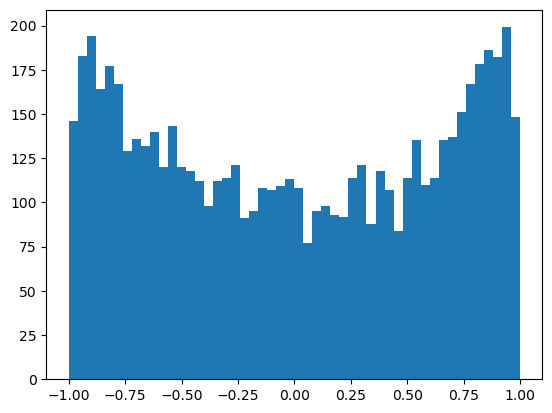

In [ ]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   1.,   3.,   4.,   5.,   2.,  18.,  16.,  27.,
         39.,  49.,  75.,  80., 132., 152., 189., 209., 228., 271., 339.,
        340., 358., 350., 392., 345., 354., 348., 295., 276., 273., 245.,
        215., 202., 130., 118.,  98.,  66.,  57.,  31.,  23.,  14.,  13.,
          5.,   4.,   4.,   1.,   2.,   1.]),
 array([-3.78352475, -3.63745856, -3.49139236, -3.34532617, -3.19925998,
        -3.05319378, -2.90712759, -2.7610614 , -2.6149952 , -2.46892901,
        -2.32286282, -2.17679662, -2.03073043, -1.88466424, -1.73859804,
        -1.59253185, -1.44646565, -1.30039946, -1.15433327, -1.00826707,
        -0.86220088, -0.71613469, -0.57006849, -0.4240023 , -0.27793611,
        -0.13186991,  0.01419628,  0.16026248,  0.30632867,  0.45239486,
         0.59846106,  0.74452725,  0.89059344,  1.03665964,  1.18272583,
         1.32879202,  1.47485822,  1.62092441,  1.7669906 ,  1.9130568 ,
         2.05912299,  2.20518919,  2.35125538,  2.49732157,  2.64338777,
 

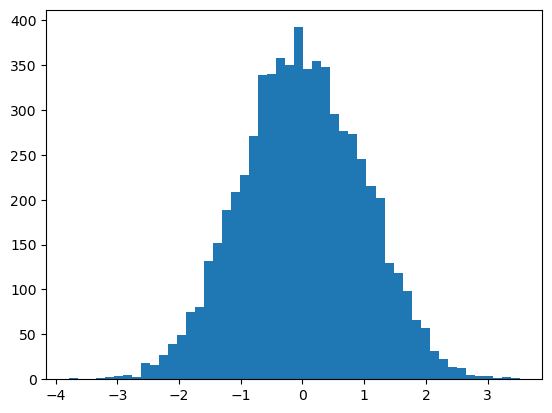

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

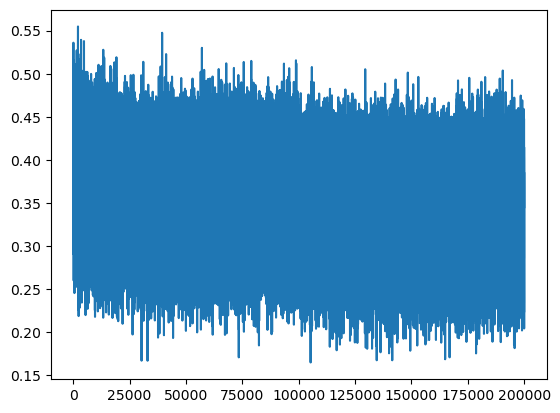

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking def split_loss(split):
def split_loss (split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb. view(emb. shape [0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, _hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy (logits, y)
    print(split, loss.item ())
split_loss ('train')
split_loss ('val')

train 3.4039876461029053
val 3.4171483516693115


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

eth.
cambayliqeqwawhnixle.
emmaxgengrlixxsharquqwew.
julianexshaequequanah.
emlengh.
karixxshug.
zixharixxtyncer.
juliqxiqpqwawobfeth.
chlyshalmekg.
lub.
hyxkquqwah.
linah.
chlushugrixxmarquqwaw.
kaviaoshmarquqwfergohshangrrixxsharthxxkharquqwin.
sirf.
cephangrli.
xttabeshlandronza.
brixah.
xval.
dexsamberxketh.
